Adapt existing randomization inference code to support power/sample size calculations

In [9]:
# import packages
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
import scipy

from matplotlib import style
from tqdm.auto import tqdm
from importlib import reload

In [44]:
# additional imports
import statsmodels.stats.power as pwr

In [11]:
# set pandas preferences
pd.options.display.max_columns=500
pd.options.display.max_colwidth=500
pd.options.display.max_rows=500

In [12]:
# set plot style
style.use("fivethirtyeight")

In [13]:
# initialize tqdm for pandas
tqdm.pandas()

In [14]:
sys.path.append("../../ab_testing_utils/") 

In [15]:
import skewed_metric_utils

In [16]:
import minimum_detectable_effect_size

In [17]:
df = pd.read_csv('../../../data/test_data_for_ri.csv')

In [18]:
df

,name,d,y,y0,y1,id_unit
0,Andy,1,10,NaN,10.0,1
1,Ben,1,5,NaN,5.0,2
2,Chad,1,16,NaN,16.0,3
3,Daniel,1,3,NaN,3.0,4
4,Edith,0,5,5.0,NaN,5
5,Frank,0,7,7.0,NaN,6
6,George,0,8,8.0,NaN,7
7,Hank,0,10,10.0,NaN,8


We assume that the dataset we have is historical:

1. Use randomization inference to generate a null distribution

2. Shift the null to get the right power for the "alternate"

3. The shift amount is the minimum detectable effect size

4. Repeat using historical samples of different sizes

5. Map sample size to expected run time given baseline number of daily observations (roll up to weeks)

6. Map run time --> minimum detectable effect size

In [82]:
ri_ = skewed_metric_utils.RandomizationInference()

In [20]:
sharp_null_type = 'additive'
sharp_null_value = 0
outcome_column_name = 'y'

In [21]:
# step 1: select sharp null
df_ = ri_.sharp_null(df_=df, 
                     sharp_null_type=sharp_null_type, 
                     sharp_null_value=sharp_null_value, 
                     outcome_column_name=outcome_column_name)

In [22]:
test_statistic = {'function': 'difference_in_means', 'params': None}

In [23]:
# Step 2: pick a test statistic. We have a list of pre-built ones, otherwise a function must be supplied
# This function must consume a DataFrame and return a single scalar value
test_statistic_function = ri_.select_test_statistic(test_statistic=test_statistic)

In [25]:
num_permutations = 1000
treatment_assignment_probability = 0.5
sample_with_replacement = True

In [26]:
# Now we can run the randomization inference step:
sim_dict = ri_.run_randomization_inference(df_=df_, 
                                           test_statistic_function=test_statistic_function, 
                                           treatment_assignment_probability=treatment_assignment_probability, 
                                           num_perms=num_permutations, 
                                           sample_with_replacement=sample_with_replacement)

Found {0} distinct assignment combinations. All combinations will be simulated.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 428.34it/s]


In [28]:
df_sims = pd.DataFrame.from_dict(sim_dict, orient='index')
df_sims = df_sims.reset_index()
df_sims.columns = ['permutation', 'test_statistic']

In [29]:
df_sims

,permutation,test_statistic
0,0,1.0
1,1,2.0
2,2,3.0
3,3,3.5
4,4,4.5
5,5,-4.5
6,6,-3.5
7,7,-3.0
8,8,-2.0
9,9,-2.5


In [30]:
# There is no observed test statistic here, so we don't have to do anything with that

In [31]:
# Ok so now we select the power and the confidence of the desired test:
power_ = 0.8
alpha = 0.05

In [49]:
# First, compute the critical value
# q_significance = 1 - alpha
q_significance = 1 - alpha/2
critical_point_ri = np.quantile(df_sims['test_statistic'].values, q_significance)

In [50]:
critical_point_ri

4.7749999999999915

In [51]:
# Now compute the minimum detectable effect size with the assumed power
q_ = 100 - power_ * 100

In [52]:
simulated_effect_size_qth_percentile = np.percentile(df_sims['test_statistic'].values, q_)

In [53]:
q_

20.0

In [54]:
simulated_effect_size_qth_percentile

-3.0

In [55]:
mme_ = critical_point_ri - simulated_effect_size_qth_percentile

In [56]:
mme_

7.7749999999999915

In [41]:
# Is this true? I feel like the negative is throwing this off somehow...do we need an absolute value here instead? 

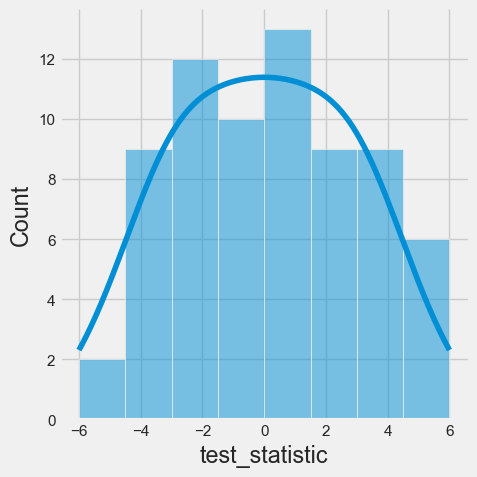

In [43]:
sns.displot(data=df_sims, x='test_statistic', kde=True)

In [45]:
pwr.tt_ind_solve_power(nobs1=4, alpha=0.05, power=0.8)

2.380754598517712

In [46]:
df_sims['test_statistic'].std()

2.8992752717617685

In [48]:
# So in terms of the mean difference, this is like
2.380754598517712 * 2.8992752717617685

6.902462935615519

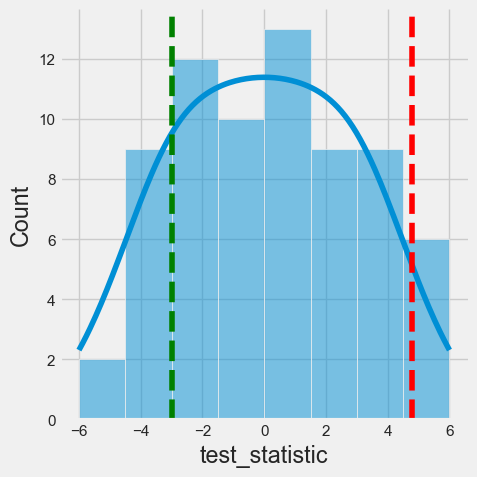

In [60]:
# Yeah ok, So for a two sided design, it should be alpha/2, otherwise, it's just alpha. 
# This minus sign is correct. We can plot it and see
g = sns.displot(data=df_sims, x='test_statistic', kde=True)
ax = g.ax
ax.axvline(x=critical_point_ri, linestyle='--', color='red')
ax.axvline(x=simulated_effect_size_qth_percentile, linestyle='--', color='green')

In [59]:
# Yeah that's it. 

<Axes: xlabel='test_statistic', ylabel='Count'>

In [61]:
# So the shifted distribution should be:
df_sims['shifted_test_statistic'] = df_sims['test_statistic'] + mme_

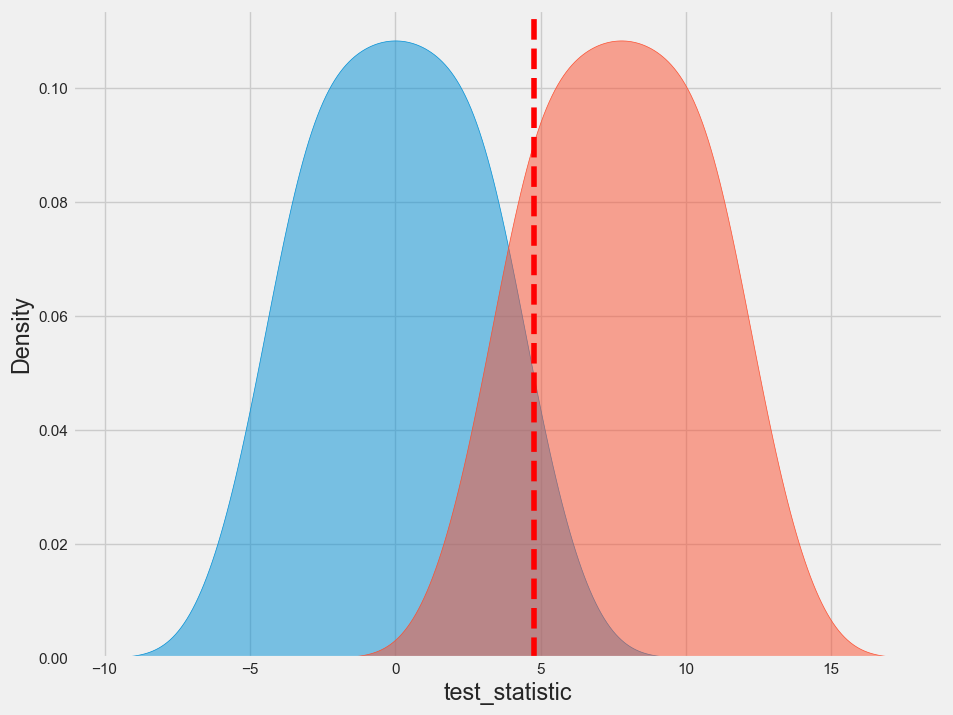

In [70]:
fig, ax = plt.subplots(figsize=(10,8))
sns.kdeplot(data=df_sims, x='test_statistic', fill=True, alpha=0.5)
sns.kdeplot(data=df_sims, x='shifted_test_statistic', fill=True, alpha=0.5)
ax.axvline(x=critical_point_ri, linestyle='--', color='red')
# ax.axvline(x=simulated_effect_size_qth_percentile + mme_, linestyle='--', color='green')

<Axes: xlabel='test_statistic', ylabel='Count'>

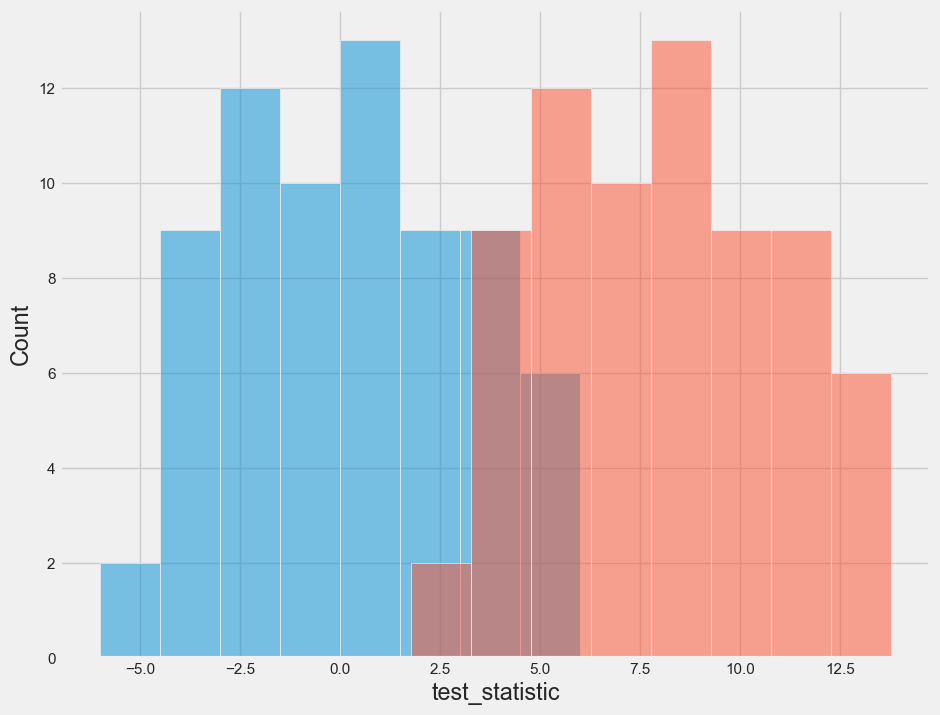

In [67]:
fig, ax = plt.subplots(figsize=(10,8))
sns.histplot(data=df_sims, x='test_statistic', fill=True, alpha=0.5)
sns.histplot(data=df_sims, x='shifted_test_statistic', fill=True, alpha=0.5)

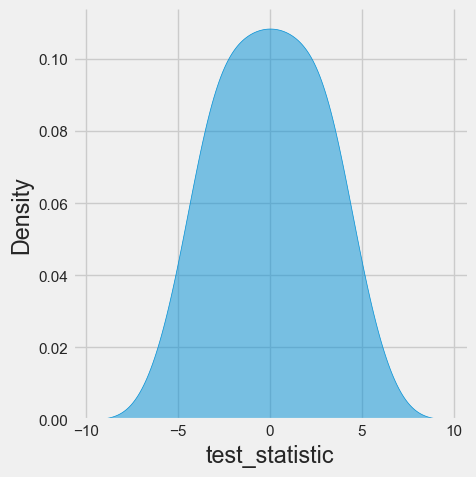

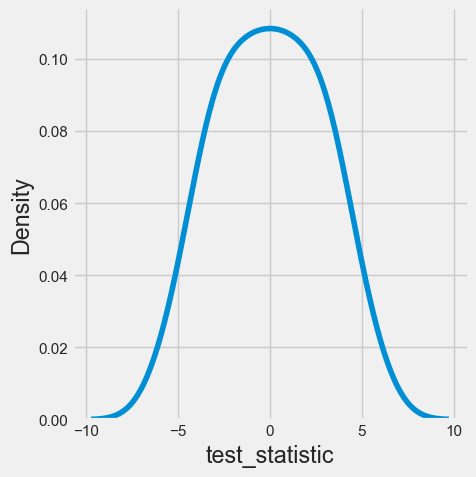

In [63]:
sns.displot(data=df_sims, x='test_statistic', kind='kde', fill=True, alpha=0.5)
sns.displot(data=df_sims, x='test_statistic', kind='kde')

In [103]:
def power_calculation(df, expected_4_week_sample_size, min_weeks, max_weeks, sharp_null_type='additive', sharp_null_value=0, test_statistic={'function': 'difference_in_means', 'params': None}, treatment_assignment_probability=0.5, outcome_column_name='y', treatment_column_name='d', treatment_name=1, control_name=0, num_permutations=1000, alternative='two-sided', confidence=0.95, sample_with_replacement=False, filename=None, output_path=None):

    # We assume that the dataset we have is historical:

    # 1. Use randomization inference to generate a null distribution

    # 2. Shift the null to get the right power for the "alternate"

    # 3. The shift amount is the minimum detectable effect size

    # 4. Repeat using historical samples of different sizes

    # 5. Map sample size to expected run time given baseline number of daily observations (roll up to weeks)

    # 6. Map run time --> minimum detectable effect size:
    
    assert sharp_null_type in ['additive', 'multiplicative'], "only additive or multiplicative sharp nulls are supported. Received {0}".format(sharp_null_type)

    assert type(num_permutations) == int, "Only an integer number of permutations is possible. Received {0}".format(num_permutations)

    assert alternative in ['two-sided', 'less', 'greater'], "Only {0} alternatives are supported. Received {0}".format(alternative)

    # We need to make sure we have enough data to support the min and max weeks desired runtime
    num_historical_units = df.shape[0]
    expected_weekly_sample_size = expected_4_week_sample_size / 4
    expected_daily_sample_size = expected_weekly_sample_size / 7
    
    assert expected_weekly_sample_size * min_weeks < num_historical_units, "Insufficient historical data for a minimum runtime of {0} weeks".format(min_weeks)
    assert expected_weekly_sample_size * max_weeks <= num_historical_units, "Insufficient historical data for a maximum runtime of {0} weeks".format(max_weeks)
    
    # Copy the input DataFrame so that we don't modify the original data in_place
    df_ = df.copy()
    
    # TODO: Do we need to do this here? Feels like code duplication. Actually, yeah we might need this
    # Save the input test statistic name if it's a string
    if type(test_statistic['function']) == str:
        test_stat_name = test_statistic['function'].replace('_', ' ')
    else:
        test_stat_name = 'custom test statistic'
    
    # We need a notion of expected sample size. So like if we expect N observations in the eligible population per 4 week period, in line with the conversion rate utils create_mde_table method
    # Ok so how do we want to do this? Just a random sample of the historical data (without replacement?)
    # First we need to generate a runtime object
    
    # Step 1: implement the selected sharp null
    df_ = self.sharp_null(df_=df_, sharp_null_type=sharp_null_type, sharp_null_value=sharp_null_value, outcome_column_name=outcome_column_name)
    
    # Step 2: pick a test statistic. We have a list of pre-built ones, otherwise a function must be supplied
    # This function must consume a DataFrame and return a single scalar value
    test_statistic_function = self.select_test_statistic(test_statistic=test_statistic)
    
    # TODO: This should be inside the self object
    # Probably don't need this
    # weeks_to_sim = range(min_weeks, max_weeks+1)
    
    effect_size_dict = {'weeks': [], 'days': [], 'total_sample_size': [], 'mde': []}
    for weeks_ in tqdm(range(min_weeks, max_weeks+1)):
        run_weeks, run_days, total_sample_size, mde = self.calculate_mme(df, weeks_, )
        effect_size_dict['weeks'].append(run_weeks)
        effect_size_dict['days'].append(run_days)
        effect_size_dict['total_sample_size'].append(total_sample_size)
        effect_size_dict['mde'] = mde
    
    df_mde = df_mde = pd.DataFrame.from_dict(effect_size_dict)
    
    # We need an output/plot option here
    
    return df_mde
    
    

SyntaxError: invalid syntax (3549030162.py, line 29)

In [ ]:
def calculate_mde(df, weeks_, expected_weekly_sample_size, sharp_null_type, sharp_null_value, outcome_column_name, test_statistic_function, num_permutations, treatment_assignment_probability, sample_with_replacenment, alternative, power, alpha):
    
    num_to_sample = weeks_ * expected_weekly_sample
    df_sample = df.sample(num_to_sample)
    
    # Determine the desired level of significance
    if alternative == 'two-sided':
        q_significance = 1 - alpha/2
    else:
        q_significance = 1 - alpha
    
    sim_dict = self.run_randomization_inference(df_=df_sample, 
                                                test_statistic_function=test_statistic_function, 
                                                treatment_assignment_probability=treatment_assignment_probability, 
                                                num_perms=num_permutations, 
                                                sample_with_replacement=sample_with_replacement)
    
    df_sims = pd.DataFrame.from_dict(sim_dict, orient='index')
    df_sims = df_sims.reset_index()
    df_sims.columns = ['permutation', 'test_statistic']
    
    # Establish the critical value for significance
    critical_point_ri = np.quantile(df_sims['test_statistic'].values, q_significance)
    
    # Set the quantile for power calculation:
    q_ = 100 - power * 100
    
    simulated_effect_size_qth_percentile = np.percentile(df_sims['test_statistic'].values, q_)
    
    # Shift the null distribution over so that 80% of its mass is to the right of the critical value. 
    # This is the minimum detectable effect size
    mde_ = critical_point_ri - simulated_effect_size_qth_percentile
    
    return weeks_, weeks_ * 7, num_to_sample, mde_
    
    # return {'weeks': weeks_, 'days': weeks_ * 7, 'total_sample_size': num_to_sample, 'mde': mde_}

In [73]:
sharp_null_type = 'additive'
sharp_null_value = 0
outcome_column_name = 'y'

[2, 3, 4, 5, 6, 7, 8, 9]

In [74]:
test_statistic = {'function': 'difference_in_means', 'params': None}
num_permutations = 1000
treatment_assignment_probability = 0.5
sample_with_replacement = True

In [88]:
alternative = 'two-sided'

In [75]:
power_ = 0.8
alpha = 0.05

In [76]:
weeks_ = 1

In [77]:
expected_weekly_sample = 8

In [78]:
# From the inputs, first we need to calculate the number of units to sample
num_to_sample = weeks_ * expected_weekly_sample

In [79]:
num_to_sample

8

In [80]:
df_sample = df.sample(num_to_sample)

In [81]:
df_sample.shape

(8, 8)

In [83]:
# Ok so that's the sample. Then we just go through as per usual
# step 1: select sharp null
df_ = ri_.sharp_null(df_=df_sample, 
                     sharp_null_type=sharp_null_type, 
                     sharp_null_value=sharp_null_value, 
                     outcome_column_name=outcome_column_name)

In [84]:
test_statistic_function = ri_.select_test_statistic(test_statistic=test_statistic)

In [85]:
# Now we can run the randomization inference step:
sim_dict = ri_.run_randomization_inference(df_=df_, 
                                           test_statistic_function=test_statistic_function, 
                                           treatment_assignment_probability=treatment_assignment_probability, 
                                           num_perms=num_permutations, 
                                           sample_with_replacement=sample_with_replacement)

Found {0} distinct assignment combinations. All combinations will be simulated.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 422.76it/s]


In [94]:
df_sims = pd.DataFrame.from_dict(sim_dict, orient='index')
df_sims = df_sims.reset_index()
df_sims.columns = ['permutation', 'test_statistic']

In [95]:
if alternative == 'two-sided':
    q_significance = 1 - alpha/2
else:
    q_significance = 1 - alpha

critical_point_ri = np.quantile(df_sims['test_statistic'].values, q_significance)

In [96]:
q_ = 100 - power_ * 100

In [97]:
simulated_effect_size_qth_percentile = np.percentile(df_sims['test_statistic'].values, q_)

In [98]:
mme_ = critical_point_ri - simulated_effect_size_qth_percentile

In [99]:
mme_

7.7749999999999915

In [104]:
from collections import namedtuple

In [105]:
fields = ['weeks', 'days', 'total_sample_size', 'mde']

In [106]:
mde_nt = namedtuple('mde', fields)

In [107]:
mde_nt

__main__.mde

In [108]:
mde_nt_1 = mde_nt(2, 14, 10000, 1.4)

In [109]:
mde_nt_1

mde(weeks=2, days=14, total_sample_size=10000, mde=1.4)

In [117]:
mde_nt_1.weeks

2

In [118]:
mde_nt_1._asdict()

{'weeks': 2, 'days': 14, 'total_sample_size': 10000, 'mde': 1.4}

In [129]:
test_dict = {'weeks': [], 'days': [], 'total_sample_size': [], 'mde': []}

In [130]:
{key: list_.append(mde_nt_1._asdict()[key]) for key, list_ in test_dict.items()}

{'weeks': None, 'days': None, 'total_sample_size': None, 'mde': None}

In [127]:
for key, list_ in test_dict.items():
    list_.append(mde_nt_1._asdict()[key])

In [128]:
test_dict

{'weeks': [2], 'days': [14], 'total_sample_size': [10000], 'mde': [1.4]}